In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/listings_june.csv')

In [3]:
# Chained assignment to work with raw data. Must turn price to float and get bathroom count from bathroom_text
june = (
    data[
        [
            "id",
            "latitude",
            "longitude",
            "room_type",
            "accommodates",
            "bedrooms",
            "beds",
            "price",
            # "availability_30",
            # "availability_60",
            # "availability_90",
            # "availability_365",
            "bathrooms_text",
        ]
    ]
    .astype({"room_type": "object"})
    .assign(
        price_float=lambda x: x.price.str.replace("[\$,]", "", regex=True).astype(
            "float"
        ),
        bathrooms_count=lambda x: x.bathrooms_text.str.extract("(\d+(?:\.\d+)?)")
        .fillna(0)
        .astype("float"),
        # year=lambda x: x.last_scraped.dt.year,
        # month=lambda x: x.last_scraped.dt.month,
        # day=lambda x: x.last_scraped.dt.day,
        # first_mo_occ=lambda x: (30 - x.availability_30),
        # second_mo_occ=lambda x: (60 - x.availability_60) - x.first_mo_occ,
        # third_mo_occ=lambda x: (90 - x.availability_90)
        # - x.first_mo_occ
        # - x.second_mo_occ,
        # month_1_revenue=lambda x: x.price_float * x.first_mo_occ,
        # month_2_revenue=lambda x: x.price_float * x.second_mo_occ,
        # month_3_revenue=lambda x: x.price_float * x.third_mo_occ,
        # total_90_day_revenue=lambda x: (90 - x.availability_90) * x.price_float,
    )
    .drop(columns=["bathrooms_text", "price"])
    .fillna(0)
)

In [4]:
initial_len = len(june)

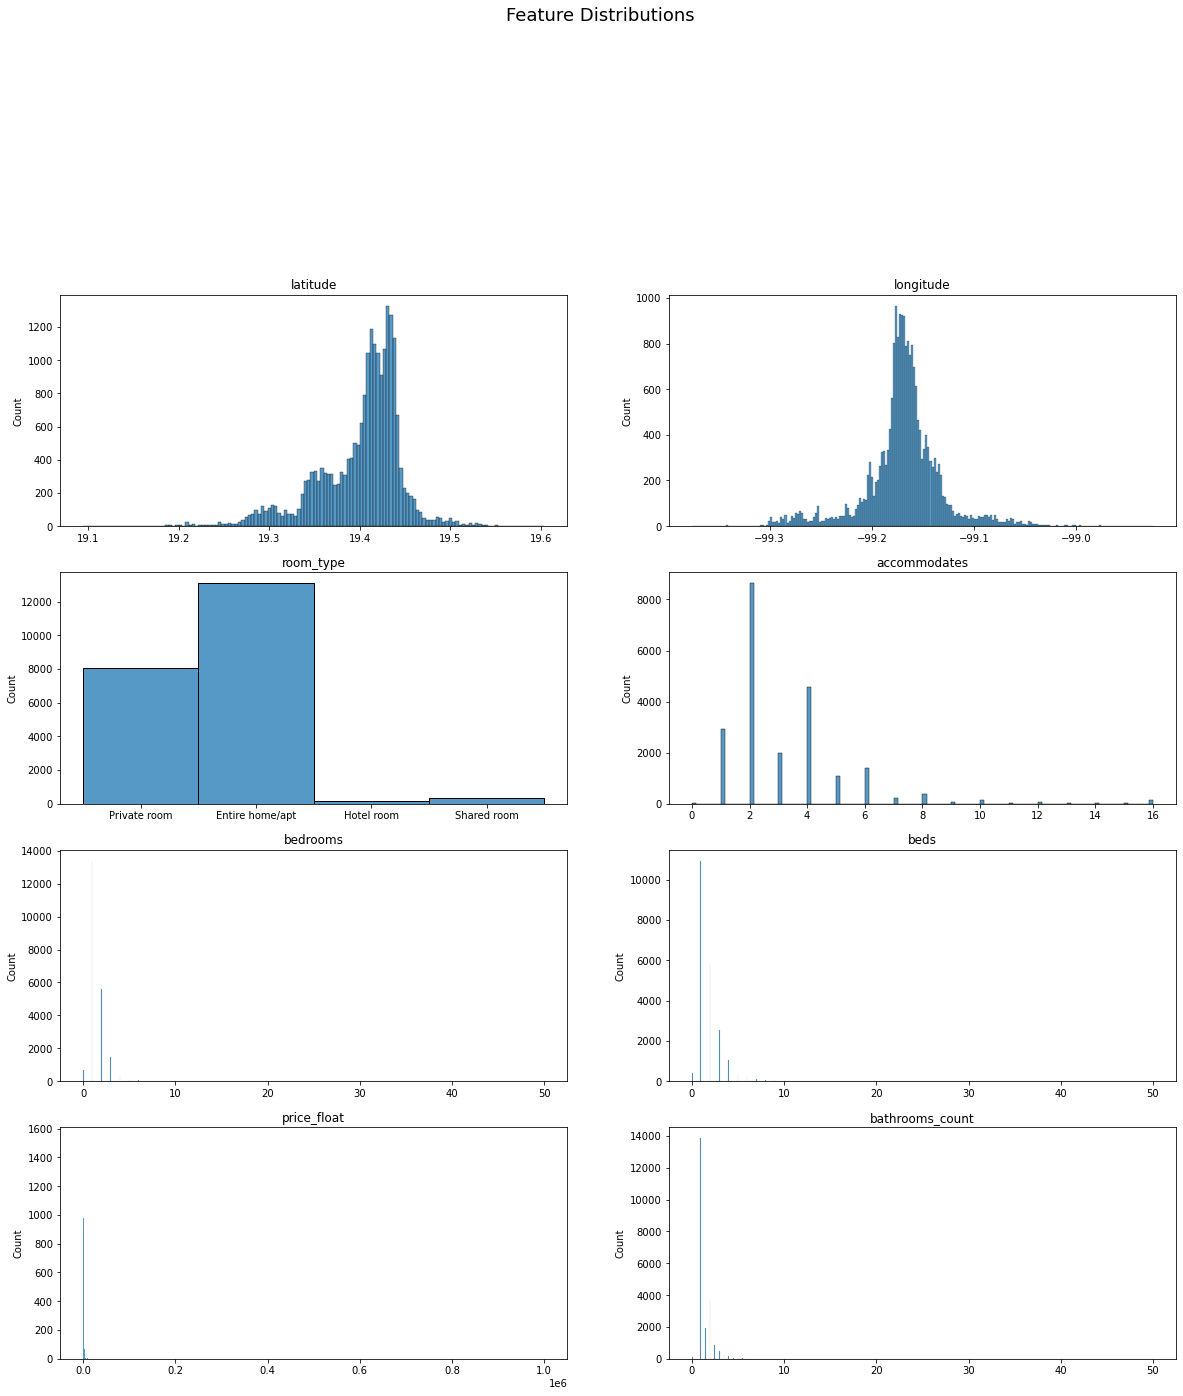

In [5]:
def plot_distributions(data):
    nums = data.select_dtypes(include=np.number)
    rows = len(data.columns)
    
    plt.figure(figsize=(20, 40))
    plt.suptitle("Feature Distributions", fontsize=18)
    for n, feature in enumerate(data.columns):
        ax = plt.subplot(rows, 2, n+1)
        sns.histplot(data=data, x=feature, ax=ax)

        ax.set_title(feature)
        ax.set_xlabel("")
    plt.show()
    pass

plot_distributions(june.drop(columns='id'))

In [6]:
def iqr(data, feature_list):
  upper_bounds = {}
  for feature in feature_list:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = (q3 - q1)*1.5
    upper_bounds[feature] = q3 + iqr
  
  return upper_bounds

In [7]:
outliers = ['bedrooms', 'beds', 'bathrooms_count']
iqrs = iqr(june, outliers)

In [8]:
# Drop Outliers
for feature in outliers:
  june = june[june[feature] < iqrs[feature]]

In [9]:
print(f"Rows dropped: {initial_len - len(june)}")

Rows dropped: 2207


In [10]:
june.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19462 entries, 0 to 21667
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               19462 non-null  int64  
 1   latitude         19462 non-null  float64
 2   longitude        19462 non-null  float64
 3   room_type        19462 non-null  object 
 4   accommodates     19462 non-null  int64  
 5   bedrooms         19462 non-null  float64
 6   beds             19462 non-null  float64
 7   price_float      19462 non-null  float64
 8   bathrooms_count  19462 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.5+ MB


## Clusters

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ct = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
    remainder='passthrough'
)

In [12]:
X = ct.fit_transform(june.drop(columns='id'))

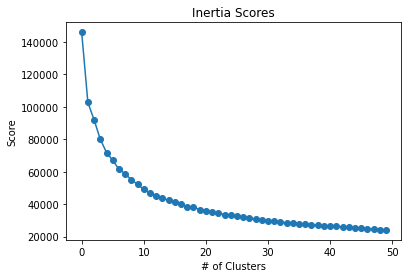

In [13]:
inertia_list = []

for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)

plt.plot(inertia_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

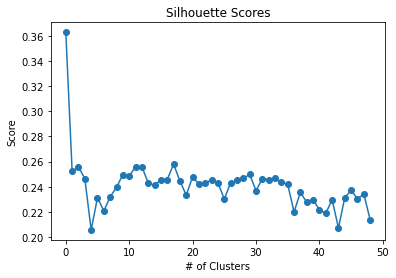

In [14]:
silhouette_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(X)
    silhouette_list.append(silhouette_score(X, kmeans.labels_))

plt.plot(silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');

8 clusters based on silhouette

In [17]:
kmeans = KMeans(n_clusters=11, random_state=12)
kmeans.fit(X)

june['cluster'] = kmeans.labels_

In [18]:
june.groupby('cluster').mean()

,id,latitude,longitude,accommodates,bedrooms,beds,price_float,bathrooms_count
cluster,,,,,,,,
0,1.043775e+17,19.411823,-99.167155,1.910547,1.084112,1.109479,911.552737,2.232977
1,9.808024e+16,19.412152,-99.072758,2.213313,1.040847,1.290469,569.847201,1.102118
2,1.003427e+17,19.411768,-99.159109,4.179218,2.063870,2.348904,1238.063394,1.061964
3,8.105419e+16,19.418172,-99.169876,2.194281,0.954894,0.978479,1271.988797,1.031987
4,2.389552e+07,19.328990,-98.976970,4.000000,2.000000,2.000000,350000.000000,1.000000
5,8.036476e+16,19.357988,-99.261232,2.090271,1.018054,1.195587,917.914744,1.109328
6,6.140469e+16,19.322606,-99.157972,1.837500,0.993519,1.147222,673.660185,1.087731
7,8.995254e+16,19.419637,-99.168744,1.685872,0.979258,1.028117,746.765153,1.058078
8,1.200038e+17,19.408872,-99.178314,4.499215,2.158655,2.422872,1997.781967,2.135407


In [19]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

<AxesSubplot:>

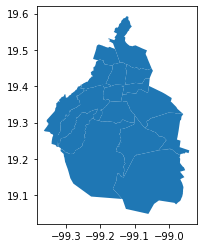

In [20]:
cdmx = gpd.read_file('data/nyu-2451-36860-shapefile/nyu_2451_36860.shp')
cdmx.plot()

In [21]:
cdmx.head()

,cvegeo,cve_ent,cve_mun,nomgeo,geometry
0,09002,09,002,Azcapotzalco,"POLYGON ((-99.18231 19.50748, -99.18229 19.507..."
1,09006,09,006,Iztacalco,"POLYGON ((-99.05584 19.42196, -99.05589 19.421..."
2,09009,09,009,Milpa Alta,"POLYGON ((-98.99723 19.22731, -98.99745 19.227..."
3,09010,09,010,Álvaro Obregón,"POLYGON ((-99.18871 19.39475, -99.18868 19.394..."
4,09013,09,013,Xochimilco,"POLYGON ((-99.09870 19.31964, -99.09849 19.319..."


In [22]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(june['longitude'], june['latitude'])]

In [23]:
geo_df = gpd.GeoDataFrame(june, crs=crs, geometry=geometry)
geo_df.head()

/Users/andresperez/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,latitude,longitude,room_type,accommodates,bedrooms,beds,price_float,bathrooms_count,cluster,geometry
0,52390579,19.395126,-99.277374,Private room,1,3.0,1.0,752.0,3.0,0,POINT (-99.27737 19.39513)
1,35797,19.382830,-99.271780,Entire home/apt,2,1.0,1.0,4056.0,1.0,5,POINT (-99.27178 19.38283)
2,15511977,19.410950,-99.244180,Private room,2,1.0,1.0,800.0,1.0,5,POINT (-99.24418 19.41095)
4,34776449,19.426410,-99.225910,Private room,3,1.0,2.0,1779.0,1.0,10,POINT (-99.22591 19.42641)
5,56074,19.439770,-99.156050,Entire home/apt,2,1.0,1.0,650.0,1.0,3,POINT (-99.15605 19.43977)


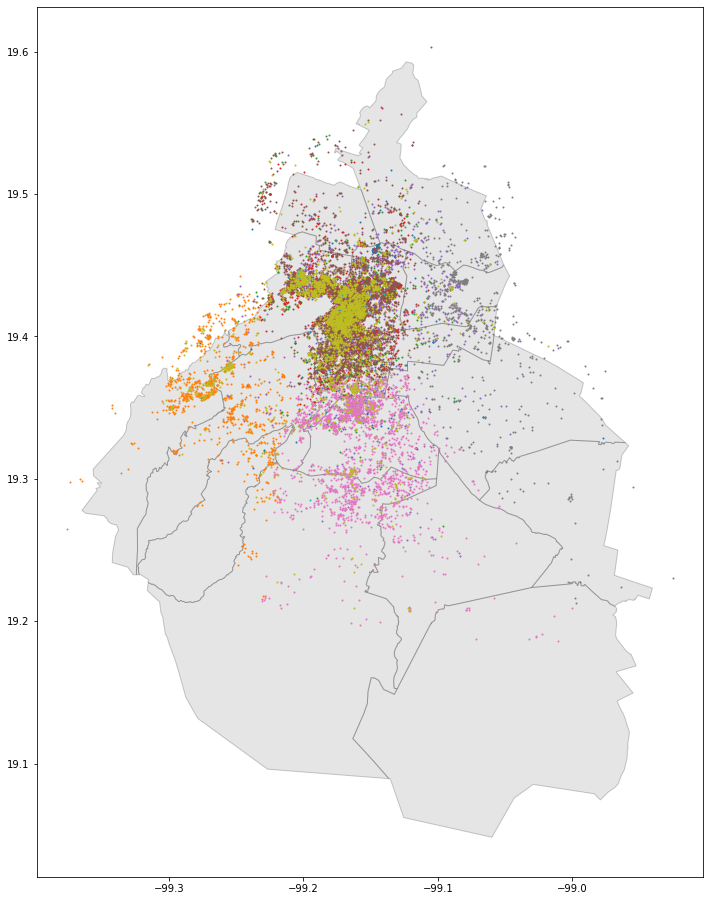

In [24]:

fig, ax = plt.subplots(figsize=(40,16))
cdmx.plot(ax=ax, alpha=.2, color='grey', edgecolor='black', legend=True)
for cluster in geo_df['cluster'].unique():
    geo_df[geo_df['cluster'] == cluster].plot(ax=ax, markersize=1)
    

In [25]:
clustered = pd.merge(
    left=june,
    right=data[
        [
            "id",
            "availability_30",
            "availability_60",
            "availability_90",
            "availability_365",
        ]
    ],
    how="left",
    on="id",
)

In [26]:
clustered

,id,latitude,longitude,room_type,accommodates,bedrooms,beds,price_float,bathrooms_count,cluster,geometry,availability_30,availability_60,availability_90,availability_365
0,52390579,19.395126,-99.277374,Private room,1,3.0,1.0,752.0,3.0,0,POINT (-99.27737 19.39513),30,60,90,365
1,35797,19.382830,-99.271780,Entire home/apt,2,1.0,1.0,4056.0,1.0,5,POINT (-99.27178 19.38283),28,58,88,363
2,15511977,19.410950,-99.244180,Private room,2,1.0,1.0,800.0,1.0,5,POINT (-99.24418 19.41095),29,59,89,179
3,34776449,19.426410,-99.225910,Private room,3,1.0,2.0,1779.0,1.0,10,POINT (-99.22591 19.42641),23,46,74,222
4,56074,19.439770,-99.156050,Entire home/apt,2,1.0,1.0,650.0,1.0,3,POINT (-99.15605 19.43977),9,39,69,344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19457,45882719,19.501490,-99.228090,Private room,1,1.0,0.0,250.0,1.0,7,POINT (-99.22809 19.50149),29,59,89,364
19458,618034488468131637,19.499980,-99.226010,Entire home/apt,4,1.0,2.0,673.0,1.0,10,POINT (-99.22601 19.49998),20,50,80,355
19459,22107097,19.507870,-99.220670,Entire home/apt,3,1.0,2.0,897.0,1.0,10,POINT (-99.22067 19.50787),0,9,39,314
19460,40617809,19.507530,-99.225060,Entire home/apt,1,1.0,1.0,230.0,1.0,3,POINT (-99.22506 19.50753),0,0,0,140
